<a href="https://colab.research.google.com/github/shiyunzhu/tSNE/blob/master/tSNE_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# tSNE Implementation
Shiyun Zhu

## Problem 1
First, we will implement the tSNE algorithm

In [0]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import distance_matrix
import scipy.optimize as opt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

First, let us write some helper functions that we will need to use for the main function.

In [0]:
def pji(x_dist, i, j, sigmai):
    '''
        This function calculates the pji 
    '''
    if i == j:
        return 0
    num = np.exp(-x_dist[i, j]/(2 * sigmai**2))
    den = np.sum(np.exp(-x_dist[i, :] / (2 * sigmai**2))) - 1
    
    if den == 0 and num == 0:
        return 0
    elif den == 0:
        return num / 1e-9

    return num / den

I am going to use the scipy minimize_scalar function to find the optimal sigma for each data point $i$ so I will need to first write the function that will be minimized. This function below calculates the absolute value of the difference between the $Perp$ and $2^{H(i)}$ where $H(i)$ is the shannon entropy.

In [0]:
def diff_fun(sigma, x_dist, i, perp):
    '''
        This function calculates the difference between the perp and the shannon
        entropy given a particular i and sigma. This function is used in
        minimization functions later.
    '''
    N = len(x_dist)
    H_i = 0
    den = np.sum(np.exp(-x_dist[i, :] / (2 * sigma**2))) - 1
    for j in range(N):
        num = np.exp(-x_dist[i, j]/(2 * sigma**2))
        # Note that there are going to be many situations where if the value
        # is zero, there will be an error so we need to catch all of these
        # situations.
        if i == j:
            p_ji = 0
        elif num == 0 and den == 0:
            p_ji = 0
        elif den == 0:
            p_ji = num/1e-9
        else:
            p_ji = num/den

        if p_ji != 0:
            H_i -= p_ji * np.log2(p_ji)
    return np.abs(perp - 2**H_i)

Now, that we have the function to minimize, we can write the function that will calculate all of the pairwise affinities. It will go through each point and minimize the above function to find the optimal sigma for that point. Then, it will calculate the $p_{j|i}$ using the optimal sigma.

In [0]:
def pairwise_affinities(X, perp):
    '''
        This function calculates the pairwise affinities and chooses the sigmas
        for each i such that it is related to the perp value. We will use the
        scipy minimize_scalar function to find the sigma that minimizes the
        function diff_fun.
        ------------------------------------------------------------------------
        Parameters:
        X - data
        perp - perplexity value
        ------------------------------------------------------------------------
        Returns:
        p - the pairwise affinities (not symmetric)
    '''
    N = len(X)
    p = np.zeros((N, N))
    # This will give us the distance matrix, with each valued squared
    x_dist = euclidean_distances(X, squared=True)
    avg_diff = 0
    for i in range(N):

        res = opt.minimize_scalar(
            fun = diff_fun,
            bounds = (0.1, 50),
            args=(x_dist, i, perp),
            method='bounded',
            options={
                'maxiter' : 1e3
            }
        )
        
        sigma = res.x
        avg_diff += diff_fun(sigma, x_dist, i, perp)
        for j in range(N):
            p[i, j] = pji(x_dist, i, j, sigma)

        if (i + 1) % (N/10) == 0:
            print('=', end='')
    
    print()
    print('Average diff is', avg_diff / N)
    return p

Now, we need a function to complete this operation:
$$p_{ij} = \frac{p_{j|i} + p_{i|j}}{2n}$$

In [0]:
def symmetric_p(p):
    '''
       This function takes the pairwise affinities and makes them symmetric
       -------------------------------------------------------------------------
       Parameters:
       p - the N by N array of pairwise affinities.
       -------------------------------------------------------------------------
       Return:
       P - the symmetric affinities where P(i,j) = (p(i,j) + p(j,i)) / (2n)
    '''
    P = np.zeros(p.shape)
    n = len(p)
    for i in range(n):
        for j in range(n):
            if i != j:
                P[i, j] = (p[i, j] + p[j, i]) / (2 * n)
    return P

Now, we need a function to calculate the lower dimension affinity using the student t's distribution. 

In [0]:
def calc_Q(Y):
    '''
        This function takes the Y and calculates the lower dimension affinities
        ------------------------------------------------------------------------
        Parameters:
        Y - the lower dimension embedding
        ------------------------------------------------------------------------
        Return:
        Q - the lower dimension affinity
    '''
    y_dist = euclidean_distances(Y, squared=True)
    num = 1 / (1 + y_dist)
    den = np.sum(1 / (1 + y_dist)) - np.trace(1 / (1 + y_dist))
    Q = np.divide(num, den)

    for i in range(len(Y)):
        Q[i, i] = 0
    
    return Q

We also need a function to calculate the gradient of the cost function that we will use during gradient descent.

In [0]:
def gradi(Y, P, Q, i):
    '''
       This function calculates the gradient of the cost function with respect
       to y_i
    '''
    N = len(Y)
    y_dist = euclidean_distances(Y, squared=True)
    grad = 0
    for j in range(N):
        grad += (P[i,j] - Q[i,j]) * (Y[i, :] - Y[j, :]) / (1 + y_dist[i, j])

    return 4 * grad

Finally, we need a function to calculate the cost. This function isn't necessary for the basic tSNE algorithm, but it is important to be able to know what the cost is and to use for an adaptive learning rate. The adaptive learning rate scheme is taken from [mathworks](https://www.mathworks.com/help/deeplearning/ref/traingda.html) and works as follows. If the cost is greater than the previous cost by a factor of 1.05, then we will decrease the learning rate by multiplying it by 0.7 and discard the changes to Y. If it is less than the previous cost, then we multiply the learning rate by 1.05. This way, we should be able to find a large enough learning rate that doesn't mess up the cost.

In [0]:
def calc_cost(P, Q, N):
    '''
        This function calculates the cost given the P and Q, where the cost is
        the KL divergence.
        ------------------------------------------------------------------------
        Parameters:
        P - the high dimensional affinities
        Q - the low dimensional affinities
        N - the number of data points
        ------------------------------------------------------------------------
        Returns:
        cost - the calculated total cost summed over every i and j
    '''
    cost = 0
    for i in range(N):
        for j in range(N):
            if i != j and P[i,j]/Q[i,j] != 0:
                cost += P[i, j] * np.log(P[i, j]/Q[i,j])
    return cost

In [0]:
def tSNE(X, perp=5, num_iter=1, num_dim=2, lr=10, adaptive=True, noise=True,
         patience=2, max_diff=1e-15):
    '''
       This function takes a dataset X and returns a 2D embedding using the
       tSNE algorithm.
       -------------------------------------------------------------------------
       Parameters:
       X - a N by D dimensional array of data (N data points, each in D
           dimensions)
       perp - the perplexity used to calculate sigma
       num_iter - the number of iterations to run the optimization for
       num_dim - the number of dimensions in the resulting embedding, default is
                 two dimensions
       lr - the starting learning rate, default is 10
       adaptive - boolean indicating usage of adaptive learning rate
       noise - boolean indicating usage of noisy gradient descent
       patience - number of iterations where stability is found before breaking
       max_diff - max difference tolerated to be considered the same
       -------------------------------------------------------------------------
       Return:
       Y - a N by num_dim array of the resulting embedding
    '''
    N = len(X)
    Y = np.random.normal(0, 1e-4, (N, num_dim))
    prev_cost = 0
    cost = 10000
    stable = 0 # counts the number of iters the cost stops changing

    print('Computing a', num_dim, 'dimensional embedding of', N, 'data points')

    # Compute pairwise affinities with perplexity perp
    print('Starting to calculate pairwise affinities...')
    p = pairwise_affinities(X, perp)

    # Set pij = ...
    P = symmetric_p(p)
    print('Starting optimization...')
    for it in range(num_iter):
        # compute low dimensional affinities qij
        Q = calc_Q(Y)

        # compute gradient
        Grad = np.zeros((N, num_dim))
        for i in range(N):
            Grad[i, :] = gradi(Y, P, Q, i)
            
        # add noise to gradient
        if noise:
            Grad += np.random.normal(0, 1e-9, (N, num_dim))

        # update y
        Y_temp = np.copy(Y)
        for i in range(N):
            Y[i, :] -= lr * Grad[i, :]
        
        prev_cost = cost
        cost = calc_cost(P, Q, N)

        if adaptive:
            if cost > 1.05 * prev_cost:
                lr *= 0.7
                Y = Y_temp
            elif cost < prev_cost:
                lr *= 1.05

        if np.abs(cost - prev_cost) < max_diff:
            stable += 1
        else:
            stable = 0

        if stable == patience:
            break

        if (it + 1) % (num_iter/10) == 0:
            print('=', end='')
    print()
    print('The algorithm has finished')
    print('The end learning rate is', lr)
    print('The end cost is', cost)
    return Y

## Tests
Now we will generate a data set with 3 parts and 300 points in total.

In [0]:
D = 10
np.random.seed(2020)
X1 = np.random.multivariate_normal(np.zeros(D), 5 * np.identity(D), size=100)
X2 = np.random.multivariate_normal(np.ones(D) * 20, 5 * np.identity(D), size=100)
X3 = np.random.multivariate_normal(np.ones(D) * -20, 5 * np.identity(D), size=100)
X = np.concatenate((X1, X2, X3), axis=0)
print(X.shape)

(300, 10)


We will run tSNE with perplexity = 5

Computing a 2 dimensional embedding of 300 data points
Starting to calculate pairwise affinities...
Average diff is 9.60049306385713e-06
Starting optimization...
The algorithm has finished
The end learning rate is 1180.7277581673923
The end cost is 1.361884041299772


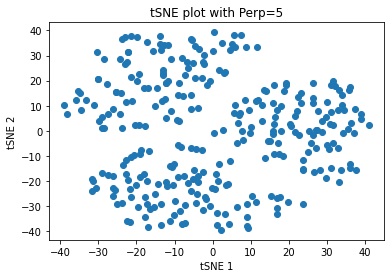

In [0]:
Y = tSNE(X, perp=5, num_iter=500)
plt.figure()
plt.scatter(Y[:,0], Y[:,1])
plt.title('tSNE plot with Perp=5')
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.show()

Now we will run tSNE on the same data with perplexity 20.

Computing a 2 dimensional embedding of 300 data points
Starting to calculate pairwise affinities...
Average diff is 2.7824335899317987e-05
Starting optimization...
The algorithm has finished
The end learning rate is 46786.96109658566
The end cost is 4.00180960099883


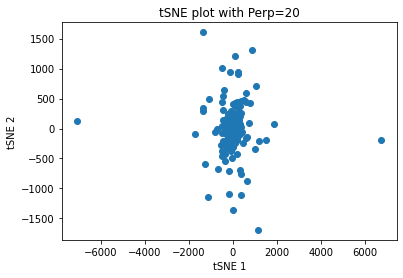

In [0]:
Y = tSNE(X, perp=20, num_iter=500)
plt.figure()
plt.scatter(Y[:,0], Y[:,1])
plt.title('tSNE plot with Perp=20')
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.show()

### Tests of Variation vs Data Points
Now lets plot the PCA projection.

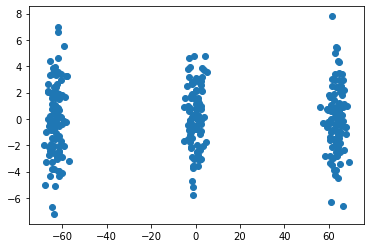

In [0]:
pca = PCA(n_components=2)
pca_Y = pca.fit_transform(X)
plt.figure()
plt.scatter(pca_Y[:,0], pca_Y[:,1])

In [0]:
D = 10
np.random.seed(2020)
X1 = np.random.multivariate_normal(np.zeros(D), 10 * np.identity(D), size=100)
X2 = np.random.multivariate_normal(np.ones(D) * 20, np.identity(D), size=100)
X3 = np.random.multivariate_normal(np.ones(D) * -20, np.identity(D), size=100)
X = np.concatenate((X1, X2, X3), axis=0)
print(X.shape)

(300, 10)


Computing a 2 dimensional embedding of 300 data points
Starting to calculate pairwise affinities...
Average diff is 1.7586873364097145e-05
Starting optimization...
The algorithm has finished
The end learning rate is 881.0772323807573
The end cost is 1.2415896045285169


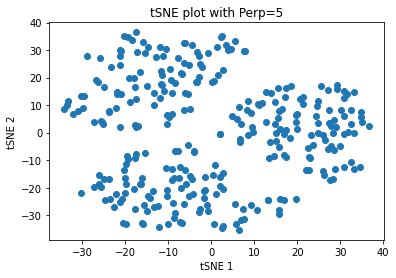

In [0]:
Y = tSNE(X, perp=5, num_iter=500, lr=10)
plt.figure()
plt.scatter(Y[:,0], Y[:,1])
plt.title('tSNE plot with Perp=5')
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.show()

Computing a 2 dimensional embedding of 300 data points
Starting to calculate pairwise affinities...
Average diff is 3.2373733231055485e-05
Starting optimization...
The algorithm has finished
The end learning rate is 54859.820004550864
The end cost is 4.6000917333551


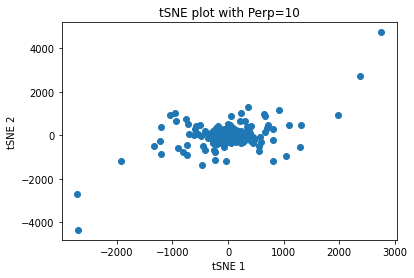

In [0]:
Y = tSNE(X, perp=10, num_iter=500, lr=100)
plt.figure()
plt.scatter(Y[:,0], Y[:,1])
plt.title('tSNE plot with Perp=10')
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.show()

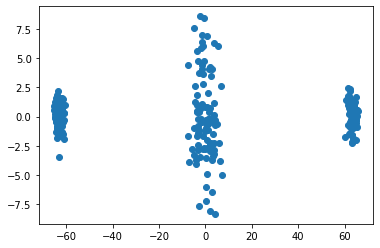

In [0]:
pca = PCA(n_components=2)
pca_Y = pca.fit_transform(X)
plt.figure()
plt.scatter(pca_Y[:,0], pca_Y[:,1])

In [0]:
D = 10
np.random.seed(2020)
X1 = np.random.multivariate_normal(np.zeros(D), 5 * np.identity(D), size=100)
X2 = np.random.multivariate_normal(np.ones(D) * 20, 5 * np.identity(D), size=50)
X3 = np.random.multivariate_normal(np.ones(D) * -20, 5 * np.identity(D), size=50)
X = np.concatenate((X1, X2, X3), axis=0)
print(X.shape)

(200, 10)


Computing a 2 dimensional embedding of 200 data points
Starting to calculate pairwise affinities...
Average diff is 1.4131317919687803e-05
Starting optimization...
The algorithm has finished
The end learning rate is 849.9361927526456
The end cost is 1.5498334554582003


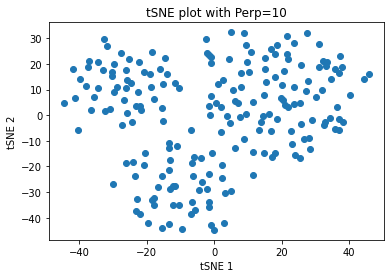

In [0]:
Y = tSNE(X, perp=10, num_iter=500, lr=100)
plt.figure()
plt.scatter(Y[:,0], Y[:,1])
plt.title('tSNE plot with Perp=10')
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.show()

Computing a 2 dimensional embedding of 200 data points
Starting to calculate pairwise affinities...
Average diff is 9.691880233395622e-06
Starting optimization...
The algorithm has finished
The end learning rate is 417.4434263038151
The end cost is 0.9676979838056228


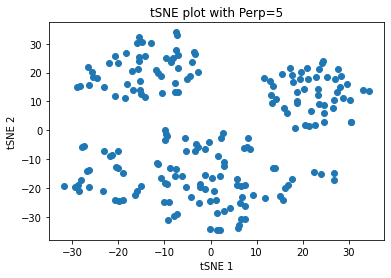

In [0]:
Y = tSNE(X, perp=5, num_iter=500, lr=10)
plt.figure()
plt.scatter(Y[:,0], Y[:,1])
plt.title('tSNE plot with Perp=5')
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.show()

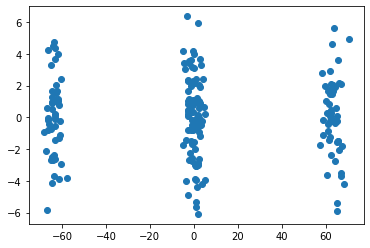

In [0]:
pca = PCA(n_components=2)
pca_Y = pca.fit_transform(X)
plt.figure()
plt.scatter(pca_Y[:,0], pca_Y[:,1])

Looking at the above plots, we see that the variance is preserved in the PCA but not the tSNE. The PCA plot clearly shows one group, the center one with higher variance but the tSNE plot displays them all with the same size. This is because in tSNE, there isn't a linear mapping of distances. Points really far apart, far apart enough to be in different groups will stay as different groups but points close together will all have a similar separation in the low dimensional mapping. Thus, that is why in part D, when we instead have a higher number of points, we see that cluster having a larger presence in the tSNE, but not a higher variance in the PCA plot.